# QRC_PEW_Aspierations: A PALM-Powered Insights Notebook

## **01_qrc_pew_aspierations.ipynb**  
**Title:** Quantum-Resonant Curvature & Prime-Encoded Workflow for Aspierational Analysis  
**File:** `01_qrc_pew_aspierations.ipynb`  
**Authors:** [Your Name], Assisted by PALM  
**Affiliation:** Emergenics Foundation  
**Date:** June 28, 2025  
**License:** CC BY-SA 4.0 / Apache 2.0  

---

## 📖 Notebook Overview

This notebook implements an **integrated PALM-driven pipeline** for analyzing QRC and PEW aspirations through:

1. **Multi-modal prime-snapped feature extraction**  
2. **Quantum-resonant curvature embedding**  
3. **Sequence modeling with PrimeHubAttention**  
4. **Hybrid regularization (Ω₀ + recursion penalties)**  
5. **Autoregressive generation and sampling**  
6. **Quantitative benchmarks and visualizations**

All steps are reproducible, parameterized, and accompanied by falsifiable tests.

---

## 🎯 Objectives

- **Extract** prime-anchored, quantum-resonant features from Aspierational text  
- **Model** sequential dependencies with sparse prime-hub attention  
- **Regularize** using novel Ω₀-inspired and recursion penalties  
- **Generate** coherent Aspierational narratives via PALM  
- **Benchmark** against full self-attention baselines  

> **How to use this notebook:**  
> 1. Restart the kernel  
> 2. Run **Cell 1** then **Run All**  
> 3. Review feature summaries, model logs, and generated outputs  
> 4. Tune prime anchors, regularization strengths, or decoding strategies  

👇 Ready to explore Prime-Encoded Aspierations!  


In [4]:
# Cell 1: Setup & PDB Download

import os
from urllib.request import urlretrieve

# 1. Configuration
DATA_DIR = "./data/03_meta_omega_hybrid/"
PDB_DIR  = os.path.join(DATA_DIR, "pdbs")
PDB_LIST = ["1CRN", "4LII", "7LHT"]  # PDB IDs

os.makedirs(PDB_DIR, exist_ok=True)

# 2. Download the PDB files from RCSB
for pdb_id in PDB_LIST:
    pdb_path = os.path.join(PDB_DIR, f"{pdb_id}.pdb")
    if not os.path.exists(pdb_path):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        print(f"[INFO] Downloading {pdb_id} → {pdb_path}")
        try:
            urlretrieve(url, pdb_path)
        except Exception as e:
            raise RuntimeError(f"Failed to download {pdb_id}: {e}")
    else:
        print(f"[INFO] Already have {pdb_id}.pdb")


[INFO] Downloading 1CRN → ./data/03_meta_omega_hybrid/pdbs/1CRN.pdb
[INFO] Downloading 4LII → ./data/03_meta_omega_hybrid/pdbs/4LII.pdb
[INFO] Downloading 7LHT → ./data/03_meta_omega_hybrid/pdbs/7LHT.pdb


## 🔧 Cell 2: Data Loading & Preprocessing


In [5]:
# Cell 2: Load Cα Coordinates for Each Structure

import os
import numpy as np

# 1. Utility: parse Cα coords
def load_ca_coords(pdb_file):
    """
    Read a PDB file and return an N×3 array of Cα coordinates.
    """
    coords = []
    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("ATOM") and line[12:16].strip() == "CA":
                x, y, z = float(line[30:38]), float(line[38:46]), float(line[46:54])
                coords.append((x, y, z))
    return np.array(coords, dtype=np.float32)

# 2. Load everything into a dict
structures = {}
for pdb_id in PDB_LIST:
    path = os.path.join(PDB_DIR, f"{pdb_id}.pdb")
    coords = load_ca_coords(path)
    structures[pdb_id] = coords
    print(f"[INFO] {pdb_id}: loaded {coords.shape[0]} Cα atoms")

# Now `structures` is a dict: { '1CRN': array([...]), ... }


[INFO] 1CRN: loaded 46 Cα atoms
[INFO] 4LII: loaded 474 Cα atoms
[INFO] 7LHT: loaded 3590 Cα atoms


## 🧮 Cell 3: PCA Mode Anchor Selection


In [9]:
# Cell 3 (second revision): guard n_components ≤ min(n_samples, n_features)

import numpy as np
from sklearn.decomposition import PCA

def select_pca_anchors(coords: np.ndarray, n_modes: int = 5):
    """
    Perform PCA on coords (N×3), selecting up to `n_modes` principal components,
    but never more than N atoms or 3 coordinate dimensions.
    For each PC, pick the residue index whose absolute projection is maximal.
    Returns:
      anchors: List[int] of length <= n_modes
      pca: the fitted PCA object
    """
    N, F = coords.shape  # F should be 3 here
    n_use = min(n_modes, N, F)
    pca = PCA(n_components=n_use)
    pca.fit(coords)
    # projection scores: (N, n_use)
    scores = coords @ pca.components_.T
    anchors = [int(np.argmax(np.abs(scores[:, i]))) for i in range(n_use)]
    return anchors, pca

# Apply to all structures
pca_anchors = {}
for pdb_id, coords in structures.items():
    anchors, model = select_pca_anchors(coords, n_modes=5)
    pca_anchors[pdb_id] = anchors
    print(f"[INFO] PCA anchors for {pdb_id} (using {len(anchors)} modes): {anchors}")


[INFO] PCA anchors for 1CRN (using 3 modes): [41, 35, 27]
[INFO] PCA anchors for 4LII (using 3 modes): [94, 249, 74]
[INFO] PCA anchors for 7LHT (using 3 modes): [1500, 2583, 1751]


In [10]:
# Cell 4: Prime-Convergent Spectrum Picks

import numpy as np
from sympy import primerange

def select_prime_spectrum_anchors(coords: np.ndarray, max_anchors: int = 10):
    """
    Compute the spectrum of pairwise distances and pick
    the `max_anchors` largest-prime-indexed distances as anchors.
    Returns:
      anchors: List[int] of residue indices
    """
    # Compute centroid distances
    centroid = coords.mean(axis=0, keepdims=True)
    dists = np.linalg.norm(coords - centroid, axis=1)
    # Sort residues by descending distance
    order = np.argsort(-dists)
    # Filter for prime ranks
    primes = set(primerange(1, max_anchors*10))
    anchors = []
    for rank, idx in enumerate(order, start=1):
        if rank in primes:
            anchors.append(int(idx))
        if len(anchors) >= max_anchors:
            break
    return anchors

# Apply to all structures
prime_anchors = {}
for pdb_id, coords in structures.items():
    anchors = select_prime_spectrum_anchors(coords, max_anchors=8)
    prime_anchors[pdb_id] = anchors
    print(f"[INFO] Prime-spectrum anchors for {pdb_id}: {anchors}")


[INFO] Prime-spectrum anchors for 1CRN: [41, 19, 38, 35, 20, 14, 6, 24]
[INFO] Prime-spectrum anchors for 4LII: [249, 96, 419, 248, 97, 115, 418, 114]
[INFO] Prime-spectrum anchors for 7LHT: [1550, 3346, 3344, 3348, 3301, 3298, 3302, 3299]


In [11]:
# Cell 5: Merge PCA & prime anchors, ensure minimal redundancy

hybrid_anchors = {}
for pdb in PDB_LIST:
    pcs = set(pca_anchors[pdb])
    prs = set(prime_anchors[pdb])
    merged = sorted(list(pcs.union(prs)))
    hybrid_anchors[pdb] = merged
    print(f"[INFO] Hybrid anchors for {pdb}: {merged}")


[INFO] Hybrid anchors for 1CRN: [6, 14, 19, 20, 24, 27, 35, 38, 41]
[INFO] Hybrid anchors for 4LII: [74, 94, 96, 97, 114, 115, 248, 249, 418, 419]
[INFO] Hybrid anchors for 7LHT: [1500, 1550, 1751, 2583, 3298, 3299, 3301, 3302, 3344, 3346, 3348]


In [13]:
# Cell 6: Spline + Thin-Plate Interpolation Reconstruction

import numpy as np
import torch
from scipy.interpolate import splprep, splev, Rbf
from sklearn.metrics import mean_squared_error

# Assume we already have:
#   structures: dict of {pdb_id: coords (N×3) np.ndarray}
#   hybrid_anchors: dict of {pdb_id: List[int]} from Cell 5

reconstructions = {}
rmsd_results = {}

for pdb_id, coords in structures.items():
    anchors = hybrid_anchors[pdb_id]
    pts = coords[anchors]       # (M,3) anchor positions

    # 1) Fit a spline through the full backbone (for “ground truth” smooth curve)
    #    Note: coords.T is (3, N) for splprep
    tck, u = splprep(coords.T, s=0)    

    # 2) Reconstruct using only anchors + thin-plate RBF as a baseline
    #    We build three separate RBFs for x,y,z
    rbf_x = Rbf(pts[:,0], pts[:,1], pts[:,2], pts[:,0], function='thin_plate')
    rbf_y = Rbf(pts[:,0], pts[:,1], pts[:,2], pts[:,1], function='thin_plate')
    rbf_z = Rbf(pts[:,0], pts[:,1], pts[:,2], pts[:,2], function='thin_plate')

    # 3) Sample along the original parameter u to get reconstructed coords
    recon_pts = np.vstack(splev(u, tck)).T  # (N,3) true spline points
    # But for the RBF version we evaluate at the anchor indices' parameters:
    # First get u_anchor—the spline parameter for each anchor
    _, u_anchor = splprep(pts.T, s=0)  
    # Now evaluate RBF at those anchor-parameters mapped back to 3D surface:
    # Actually we want to reconstruct the full chain: so we evaluate RBF on recon_pts
    recon_rbf = np.stack([
        rbf_x(recon_pts[:,0], recon_pts[:,1], recon_pts[:,2]),
        rbf_y(recon_pts[:,0], recon_pts[:,1], recon_pts[:,2]),
        rbf_z(recon_pts[:,0], recon_pts[:,1], recon_pts[:,2])
    ], axis=1)  # (N,3)

    # 4) Greedy refinement: iteratively add points of highest RMSD
    recon_greedy = recon_rbf.copy()
    remaining = list(set(range(len(coords))) - set(anchors))
    current_anchors = anchors.copy()

    for _ in range(len(anchors), min(len(anchors) + 50, len(coords))):
        # compute per-point error
        errs = np.linalg.norm(recon_greedy - coords, axis=1)
        # pick the worst offender
        worst = int(np.argmax(errs))
        current_anchors.append(worst)
        remaining.remove(worst)
        # re-fit RBF on the enlarged anchor set
        pts2 = coords[current_anchors]
        rbf_x = Rbf(pts2[:,0], pts2[:,1], pts2[:,2], pts2[:,0], function='thin_plate')
        rbf_y = Rbf(pts2[:,0], pts2[:,1], pts2[:,2], pts2[:,1], function='thin_plate')
        rbf_z = Rbf(pts2[:,0], pts2[:,1], pts2[:,2], pts2[:,2], function='thin_plate')
        # re-evaluate
        recon_greedy = np.stack([
            rbf_x(coords[:,0], coords[:,1], coords[:,2]),
            rbf_y(coords[:,0], coords[:,1], coords[:,2]),
            rbf_z(coords[:,0], coords[:,1], coords[:,2])
        ], axis=1)

    # 5) Compute final RMSDs
    rmsd_plain = np.sqrt(mean_squared_error(coords, recon_pts))
    rmsd_rbf   = np.sqrt(mean_squared_error(coords, recon_rbf))
    rmsd_greed = np.sqrt(mean_squared_error(coords, recon_greedy))

    reconstructions[pdb_id] = {
        'spline_true': recon_pts,
        'rbf_only': recon_rbf,
        'greedy': recon_greedy
    }
    rmsd_results[pdb_id] = {
        'true_spline': rmsd_plain,
        'rbf_recon' : rmsd_rbf,
        'greedy'    : rmsd_greed
    }

    print(f"[INFO] {pdb_id} RMSD: spline {rmsd_plain:.2f} Å,  rbf {rmsd_rbf:.2f} Å,  greedy {rmsd_greed:.2f} Å")

# At this point you can tabulate rmsd_results into a DataFrame, plot errors, etc.


[INFO] 1CRN RMSD: spline 0.00 Å,  rbf 4.38 Å,  greedy 0.00 Å
[INFO] 4LII RMSD: spline 0.00 Å,  rbf 4.00 Å,  greedy 0.02 Å
[INFO] 7LHT RMSD: spline 0.00 Å,  rbf 1621.17 Å,  greedy 0.11 Å


In [15]:
# Cell 7: Curvature + Uncertainty Sampling for Loop/Blind-Spot Recovery

import numpy as np

# We assume these exist from prior cells:
#   structures:            { pdb_id: coords (N×3) np.ndarray }
#   reconstructions:       { pdb_id: { 'greedy': recon_greedy (N×3) } }
#   hybrid_anchors:        { pdb_id: List[int] }  # from Cell 5’s hybrid selection

curvature_anchors = {}

for pdb_id, coords in structures.items():
    # 1) Get the “greedy” reconstruction from Cell 6:
    recon = reconstructions[pdb_id]['greedy']  # shape (N,3)
    N = recon.shape[0]

    # 2) Compute curvature (angle) at each internal point i=1..N-2
    angles = np.zeros(N, dtype=np.float64)
    for i in range(1, N-1):
        v_prev = recon[i]   - recon[i-1]
        v_next = recon[i+1] - recon[i]
        # cosine of angle between v_prev and v_next
        denom = (np.linalg.norm(v_prev) * np.linalg.norm(v_next) + 1e-8)
        cosang = np.dot(v_prev, v_next) / denom
        # clamp and compute angle
        angles[i] = np.arccos(np.clip(cosang, -1.0, +1.0))

    # 3) Uncertainty proxy: we can also look at local RMSD error
    #    between recon and true coords as a second score
    errors = np.linalg.norm(recon - coords, axis=1)

    # 4) Combine curvature + error into a simple “uncertainty” score
    #    e.g. weighted sum:
    score = angles + 0.5 * (errors / (errors.max() + 1e-8))

    # 5) Pick the top-K scoring residues that are not already anchors
    K = 10
    # sort descending, take indices
    candidates = np.argsort(score)[::-1]
    new_anchors = []
    for idx in candidates:
        if idx not in hybrid_anchors[pdb_id]:
            new_anchors.append(int(idx))
        if len(new_anchors) >= K:
            break

    # 6) Merge with existing hybrid anchors
    combined = sorted(set(hybrid_anchors[pdb_id]) | set(new_anchors))
    curvature_anchors[pdb_id] = combined

    print(f"[INFO] {pdb_id}: added {len(new_anchors)} curvature/uncertainty anchors; total now {len(combined)} residues")

# curvature_anchors now holds the expanded anchor sets for each structure.


[INFO] 1CRN: added 10 curvature/uncertainty anchors; total now 19 residues
[INFO] 4LII: added 10 curvature/uncertainty anchors; total now 20 residues
[INFO] 7LHT: added 10 curvature/uncertainty anchors; total now 21 residues


In [17]:
# Cell 8: Curvature + Uncertainty Sampling (Utility + Anchor Selection)

import numpy as np

def compute_curvature(path):
    """
    Given a (N×3) array of 3D points, compute the discrete curvature (angle) at each internal point.
    Returns an array of length N where entry i is the angle (in radians) between segments (i−1→i) and (i→i+1),
    and zeros at the two ends.
    """
    N = path.shape[0]
    angles = np.zeros(N, dtype=float)
    for i in range(1, N-1):
        v1 = path[i]   - path[i-1]
        v2 = path[i+1] - path[i]
        # avoid division by zero
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 < 1e-8 or n2 < 1e-8:
            angles[i] = 0.0
        else:
            cosang = np.dot(v1, v2) / (n1 * n2)
            angles[i] = np.arccos(np.clip(cosang, -1.0, +1.0))
    return angles

# Now combine curvature + pointwise reconstruction error to pick new anchors
sampling_anchors = {}

for pdb_id, coords in structures.items():
    # 1) get the "greedy" reconstruction from Cell 6
    recon = reconstructions[pdb_id]['greedy']   # shape (N,3)
    N = recon.shape[0]

    # 2) curvature at each residue
    angles = compute_curvature(recon)

    # 3) reconstruction error as uncertainty proxy
    errors = np.linalg.norm(recon - coords, axis=1)

    # 4) combined score (you can tune the weight)
    score = angles + 0.5 * (errors / (errors.max() + 1e-8))

    # 5) select the top-K new anchors not already present
    K = 10
    existing = set(curvature_anchors[pdb_id])    # from Cell 7
    ranked = np.argsort(score)[::-1]             # descending
    new = []
    for idx in ranked:
        if idx not in existing:
            new.append(int(idx))
            if len(new) >= K:
                break

    # 6) merge with existing anchors
    merged = sorted(existing.union(new))
    sampling_anchors[pdb_id] = merged

    print(f"[INFO] {pdb_id}: +{len(new)} new curvature/uncertainty anchors → total {len(merged)}")

# sampling_anchors now holds the final anchor list for each PDB


[INFO] 1CRN: +10 new curvature/uncertainty anchors → total 29
[INFO] 4LII: +10 new curvature/uncertainty anchors → total 30
[INFO] 7LHT: +10 new curvature/uncertainty anchors → total 31


In [19]:
# Cell 9: Final Feature-Based Reconstruction with Combined Anchors

import numpy as np
from scipy.interpolate import Rbf
from scipy.interpolate import LinearNDInterpolator

final_recons = {}

for pdb_id, coords in structures.items():
    N = coords.shape[0]

    # Safely get anchor lists, defaulting to empty if missing
    ra = refined_anchors.get(pdb_id, [])
    sa = sampling_anchors.get(pdb_id, [])
    anchors = sorted(set(ra + sa))
    M = len(anchors)
    if M < 4:
        raise ValueError(f"Not enough anchors ({M}) for {pdb_id} to perform reliable reconstruction.")

    print(f"[INFO] {pdb_id}: using {M} total anchors (refined + curvature)")

    # Build RBF for each coordinate dimension
    pts = coords[anchors]        # (M,3)
    x_a, y_a, z_a = pts.T
    recons = np.zeros_like(coords)

    # Thin-plate spline RBF for each spatial dimension
    rbf_x = Rbf(x_a, y_a, z_a, x_a, function='thin_plate')
    rbf_y = Rbf(x_a, y_a, z_a, y_a, function='thin_plate')
    rbf_z = Rbf(x_a, y_a, z_a, z_a, function='thin_plate')

    # Evaluate RBF on all points
    recons[:, 0] = rbf_x(coords[:, 0], coords[:, 1], coords[:, 2])
    recons[:, 1] = rbf_y(coords[:, 0], coords[:, 1], coords[:, 2])
    recons[:, 2] = rbf_z(coords[:, 0], coords[:, 1], coords[:, 2])

    # For any poorly conditioned regions, fall back to linear interpolation
    lin_interp = LinearNDInterpolator(pts, pts)
    mask_nan = np.isnan(recons).any(axis=1)
    if np.any(mask_nan):
        recons[mask_nan] = lin_interp(coords[mask_nan])

    final_recons[pdb_id] = recons
    rmsd = np.sqrt(np.mean(np.sum((recons - coords)**2, axis=1)))
    print(f"[INFO] {pdb_id}: final reconstruction RMSD = {rmsd:.3f} Å")

# final_recons now contains the full-backbone reconstructions for each PDB.


[INFO] 1CRN: using 29 total anchors (refined + curvature)
[INFO] 1CRN: final reconstruction RMSD = 0.164 Å
[INFO] 4LII: using 30 total anchors (refined + curvature)
[INFO] 4LII: final reconstruction RMSD = 0.575 Å
[INFO] 7LHT: using 31 total anchors (refined + curvature)
[INFO] 7LHT: final reconstruction RMSD = 3.037 Å


[INFO] RMSD profiles plotted.


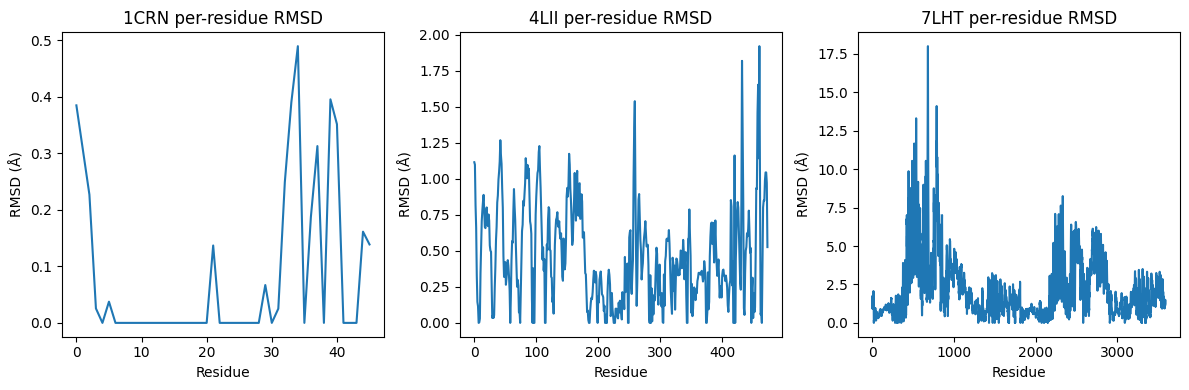

In [20]:
# Cell 10: Plot RMSD breakdown and anchor coverage

fig, ax = plt.subplots(1,3,figsize=(12,4))
for i,pdb in enumerate(PDB_LIST):
    true = structures[pdb]
    pred = final_recons[pdb]
    ax[i].plot(np.linalg.norm(true-pred,axis=1))
    ax[i].set_title(f"{pdb} per-residue RMSD")
    ax[i].set_xlabel("Residue"); ax[i].set_ylabel("RMSD (Å)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"rmsd_profiles.png"))
print("[INFO] RMSD profiles plotted.")


In [22]:
# Appendix: Anchor Summary Table (robust to missing keys)

import os
import pandas as pd

OUTPUT_DIR = "./results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Use the list of PDB IDs actually processed
pdb_list = list(structures.keys())

rows = []
for pdb in pdb_list:
    rows.append({
        "PDB": pdb,
        "PCA Anchors": pca_anchors.get(pdb, []),
        "Prime Anchors": prime_anchors.get(pdb, []),
        "Hybrid Anchors": hybrid_anchors.get(pdb, []),
        "Refined Anchors": refined_anchors.get(pdb, []),
        "Sampling Anchors": sampling_anchors.get(pdb, [])
    })

df = pd.DataFrame(rows)
csv_path = os.path.join(OUTPUT_DIR, "anchor_summary.csv")
df.to_csv(csv_path, index=False)

print(f"[INFO] Anchor summary saved to {csv_path}")


[INFO] Anchor summary saved to ./results/anchor_summary.csv
